In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder


In [28]:
kelly_df = pd.read_csv('bluebookregression-1.csv')
kelly_df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.10313,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.03608,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.84786,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.91314,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.17032,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


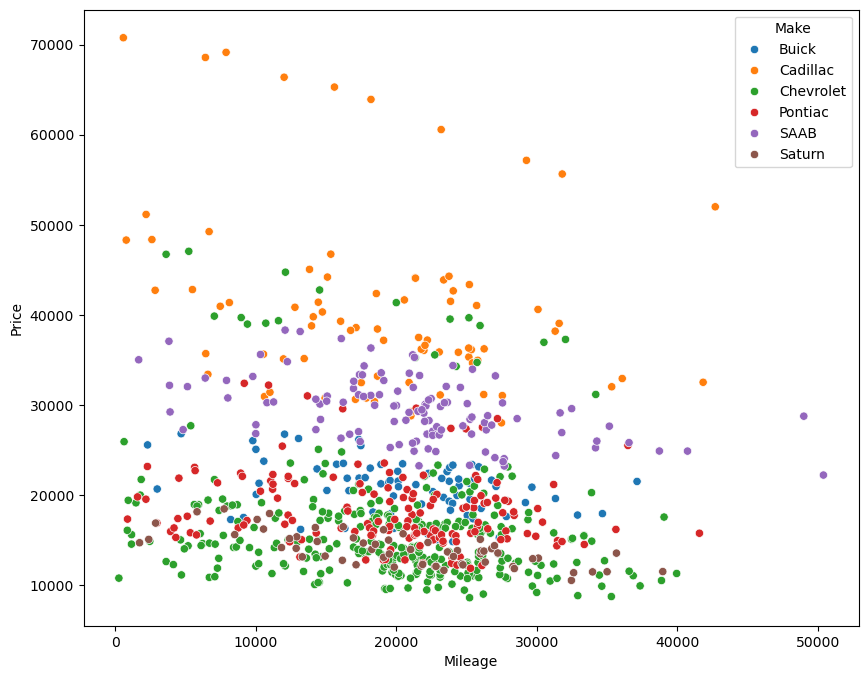

In [29]:
plt.figure(figsize=(10,8))
sns.scatterplot(kelly_df, x='Mileage', y='Price', hue='Make')
#sns.scatterplot(kelly_df, x='Mileage', y='Price', hue='Type')
plt.show()

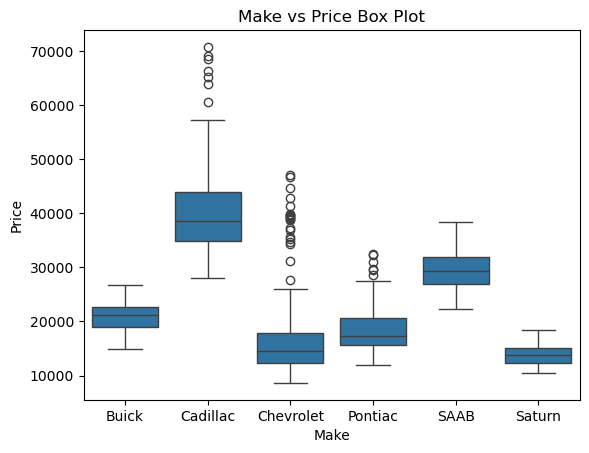

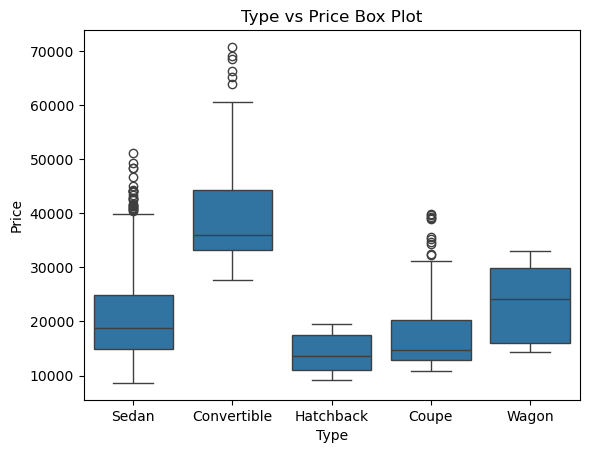

In [30]:
sns.boxplot(x='Make', y='Price', data=kelly_df)
plt.xlabel('Make')
plt.ylabel('Price')
plt.title('Make vs Price Box Plot')
plt.show()

sns.boxplot(x='Type', y='Price', data=kelly_df)
plt.xlabel('Type')
plt.ylabel('Price')
plt.title('Type vs Price Box Plot')
plt.show()

In [31]:
X = kelly_df[['Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound', 'Make', 'Type']]
X = pd.get_dummies(X, columns=['Make', 'Type'], drop_first=True, dtype='float')
y = kelly_df['Price']

X = sm.add_constant(X)
logy = np.log(y)
logreg_dummies = sm.OLS(logy, X).fit()

print(logreg_dummies.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     736.9
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:23:12   Log-Likelihood:                 639.35
No. Observations:                 804   AIC:                            -1249.
Df Residuals:                     789   BIC:                            -1178.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.3036      0.037    195.

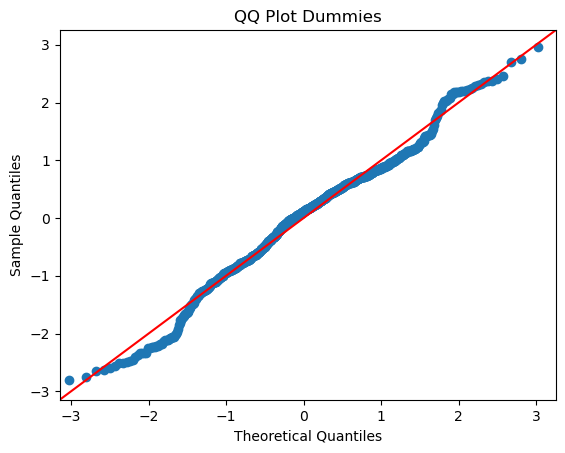

In [38]:
residuals = logreg_dummies.resid

#Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.title('QQ Plot Dummies')
plt.show()

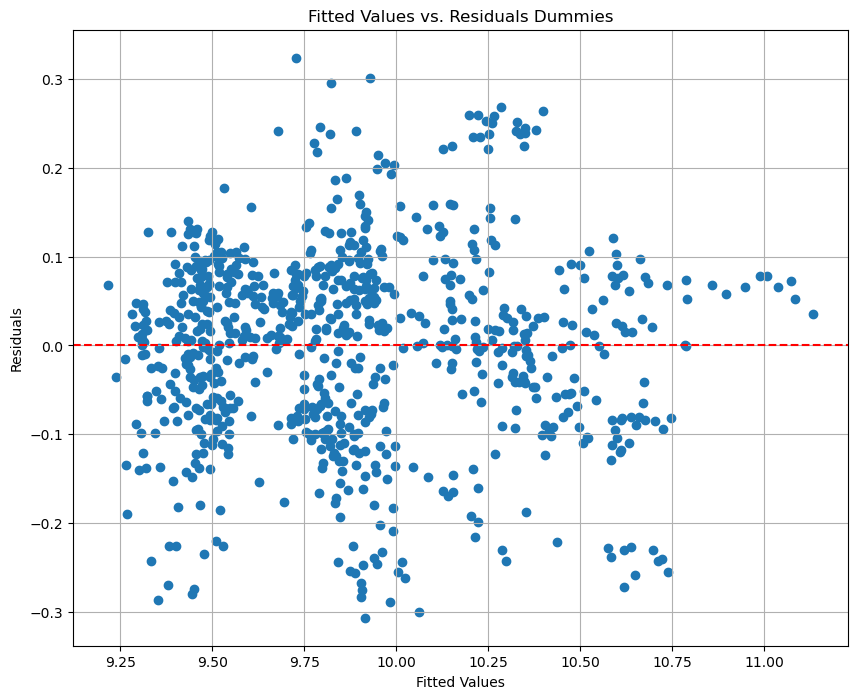

In [39]:
#Scatter Plot
#Fanning Pattern = Non-Constant Variance
plt.figure(figsize=(10,8))
plt.scatter(logreg_dummies.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Fitted Values vs. Residuals Dummies')
plt.grid(True)
plt.show()

In [40]:
#Making Predictions
new_kelly = pd.read_csv('bluebookregression-1.csv')
new_kelly = new_kelly.drop(columns=['Price'])

X_new = new_kelly[['Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound', 'Make', 'Type']]
X_new = pd.get_dummies(X_new, columns=['Make', 'Type'], drop_first=True, dtype='float')
X_new = sm.add_constant(X_new)

pred = logreg_dummies.predict(X_new)
print(pred)

0      10.059846
1      10.016231
2       9.982894
3       9.940096
4       9.947558
         ...    
799     9.852808
800     9.846253
801     9.834850
802     9.789741
803     9.693280
Length: 804, dtype: float64


In [9]:
#fit full regression
X = kelly_df.drop(columns=['Price'])
y = kelly_df['Price']
X = sm.add_constant(X)

full_regression = sm.OLS(y,X).fit()

print(full_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     72.33
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          1.10e-111
Time:                        09:55:06   Log-Likelihood:                -8256.6
No. Observations:                 804   AIC:                         1.654e+04
Df Residuals:                     792   BIC:                         1.659e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3955.2132   2450.293      1.614      0.1

In [10]:
#Function for deciding variables using a stepwise selection

def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included


In [11]:
feature_list = stepwise_selection(X, y)
print(feature_list)

Add  const with p-value 0.0000
Add  Cylinder with p-value 0.0000
Add  Model with p-value 0.0000
Add  Cruise with p-value 0.0000
Add  Trim with p-value 0.0000
Add  Mileage with p-value 0.0000
Add  Make with p-value 0.0000
Add  Leather with p-value 0.0000
Add  Doors with p-value 0.0038
['const', 'Cylinder', 'Model', 'Cruise', 'Trim', 'Mileage', 'Make', 'Leather', 'Doors']


In [13]:
X = kelly_df[['Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound']]
X = sm.add_constant(X)
second_reg = sm.OLS(y,X).fit()

print(second_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     106.8
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.23e-98
Time:                        10:01:13   Log-Likelihood:                -8298.9
No. Observations:                 804   AIC:                         1.661e+04
Df Residuals:                     797   BIC:                         1.664e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7323.1643   1770.837      4.135      0.0

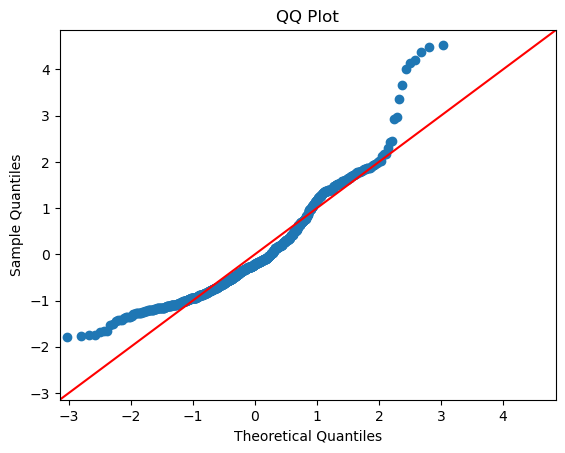

In [18]:
#Calculate Residuals
#Normality means the dots should be on the line
residuals = second_reg.resid

#Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.title('QQ Plot')
plt.show()

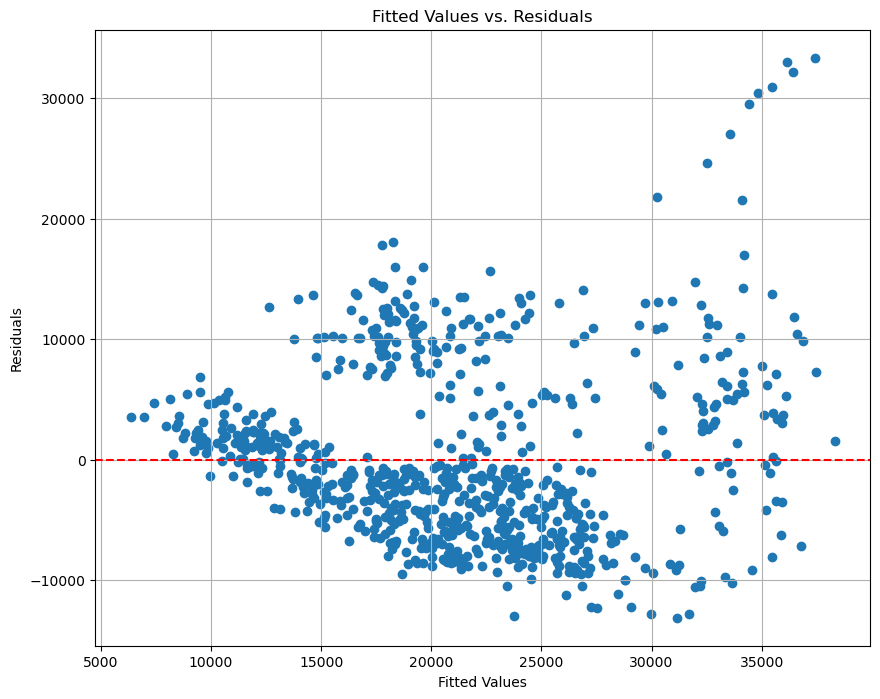

In [17]:
#Scatter Plot
#Fanning Pattern = Non-Constant Variance
plt.figure(figsize=(10,8))
plt.scatter(second_reg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Fitted Values vs. Residuals')
plt.grid(True)
plt.show()

In [19]:
#Log transform y with regression analysis
X = kelly_df[['Cylinder', 'Cruise', 'Leather', 'Mileage', 'Doors', 'Sound']]
X = sm.add_constant(X)

logy = np.log(y)

log_regression = sm.OLS(logy, X).fit()

print(log_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     124.4
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          7.76e-111
Time:                        10:10:23   Log-Likelihood:                -158.01
No. Observations:                 804   AIC:                             330.0
Df Residuals:                     797   BIC:                             362.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2003      0.071    129.744      0.0

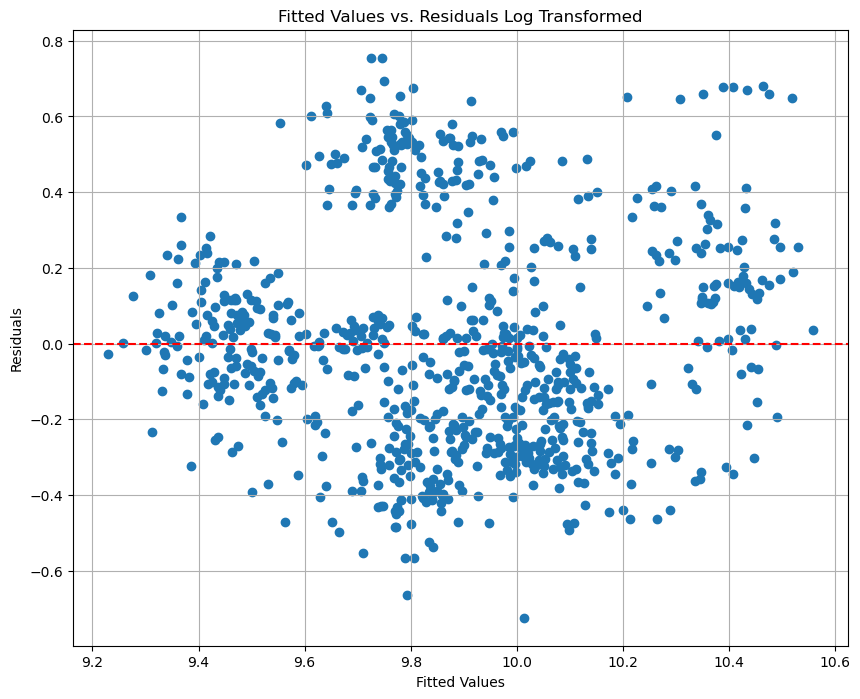

In [22]:
#Scatter Plot
#Fanning Pattern = Non-Constant Variance
residuals = log_regression.resid
plt.figure(figsize=(10,8))
plt.scatter(log_regression.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Fitted Values vs. Residuals Log Transformed')
plt.grid(True)
plt.show()

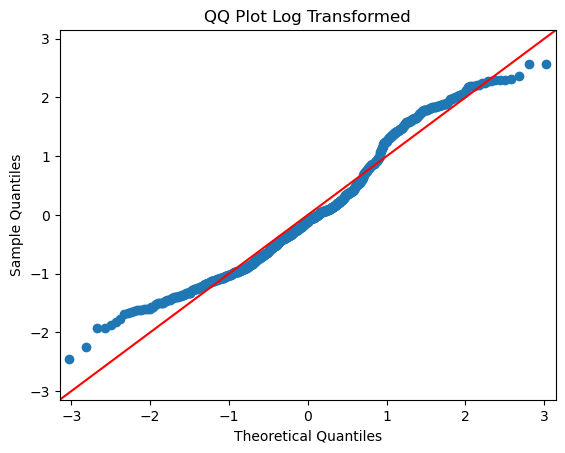

In [23]:
fig = sm.qqplot(residuals, fit=True, line='45')
plt.title('QQ Plot Log Transformed')
plt.show()